In [1]:
%matplotlib inline

import os, math, time, sys, shutil
import numpy as np
from pathlib import Path

from tifffile import imread, imwrite
# from imageio import mimwrite
import matplotlib.pyplot as plt


# import json

from gvxrPython3 import gvxr
#from gvxrPython3 import gvxr2json
from gvxrPython3 import json2gvxr
from gvxrPython3.utils import visualise, loadSpectrumSpekpy, loadSpectrumXpecgen, has_spekpy, has_xpecgen
# from untitled import visualise, loadSpectrumSpekpy, loadSpectrumXpecgen, has_spekpy, has_xpecgen


import utils
from utils import *

# import astra

SimpleGVXR 2.0.7 (2023-11-06T20:30:06) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 2.0.7 (2023-11-06T20:30:04) [Compiler: Microsoft Visual Studio] on Windows


In [2]:
registration_dir = os.path.join(base_dir, "registration")

if not os.path.exists(registration_dir):
    os.mkdir(registration_dir)

In [3]:
experimental_img_dir = os.path.join(base_dir, "Tomography_01_all_proj")
experimental_img_paths = sorted(
    [
        os.path.join(experimental_img_dir, fname)
        for fname in os.listdir(experimental_img_dir)
        if fname.endswith(".tif")
    ]
)

In [4]:
# data = np.loadtxt(base_dir + "/geom.csv", 
#     delimiter=';',
#     skiprows=2,
#     usecols=(1,2,3,4,5,6,7,8,9,10,11,12))

# new_columns = [
#     "source - x",
#     "source - y",
#     "source - z",
#     "Imager Center - x",
#     "Imager Center - y",
#     "Imager Center - z",
#     "Imager Top - x",
#     "Imager Top - y",
#     "Imager Top - z",
#     "Imager Right - x",
#     "Imager Right - y",
#     "Imager Right - z"
# ]

XraykV=120

SrcToObject=77.9902725219727
SrcToDetector=990.8258


odd = SrcToDetector - SrcToObject
sod = SrcToObject

DetectorPixelsX=1008
DetectorPixelsY=1008
DetectorPixelSizeX=0.127
DetectorPixelSizeY=0.127

#AngularStep=0.227416298168035
Projections=663
WhiteLevel=60000

N_slices = Projections
angles = [np.linspace(0, 360, N_slices, False)]

# We checked that AngularStep is equal to (angles[1] - angles[0])

In [5]:
# rx_shape = rx_dimy, rx_dimx

# source_position = data[:,:3]
# detector_position = data[:,3:6]
# detector_v = (data[:,6:9] - detector_position) / rx_shape[1] * 2
# detector_u = (data[:,9:] - detector_position) / rx_shape[0] * 2

# Y = 0.5 * source_position[:,1].mean() + 0.5 * detector_position[:,1].mean()
# source_position[:,1] -= Y
# detector_position[:,1] -= Y

# # Modify the coordinate system
# # X -> Y
# # Y -> Z
# # Z -> X
# source_position = np.roll(source_position, 1, axis=1)
# detector_position = np.roll(detector_position, 1, axis=1)
# detector_v = np.roll(detector_v, 1, axis=1)
# detector_u = np.roll(detector_u, 1, axis=1)

# sod = np.sum(source_position**2, axis=1)**.5
# sdd = np.sum((source_position-detector_position)**2, axis=1)**.5
# odd = np.sum(detector_position**2, axis=1)**.5

# print("SOD:", sod.mean(), "+/-", sod.std())
# print("SDD:", odd.mean(), "+/-", sdd.std())
# print("ODD:", odd.mean(), "+/-", odd.std())

In [6]:
# Create an OpenGL context
print("Create an OpenGL context")
gvxr.createOpenGLContext();

Create an OpenGL context


In [7]:
# if has_spekpy:
#     loadSpectrumSpekpy(XraykV, filters=None, th_in_deg=12)
# elif has_xpecgen:
#     loadSpectrumXpecgen(XraykV, filters=None, th_in_deg=12)

# Load the spectrum
# if has_spekpy:
#    loadSpectrumSpekpy(XraykV, filters=None, th_in_deg=12);
# elif has_xpecgen:
#    loadSpectrumXpecgen(XraykV, filters=None, th_in_deg=12);
# else:
#     raise Error("You must install either Spekpy or Xpecgen");

In [8]:
# if has_spekpy:
#     loadSpectrumSpekpy(XraykV, filters=None, th_in_deg=12)
# elif has_xpecgen:
#     loadSpectrumXpecgen(XraykV, filters=None, th_in_deg=12)

if has_xpecgen:
    loadSpectrumXpecgen(XraykV, filters=None, th_in_deg=12)
elif has_spekpy:
    loadSpectrumSpekpy(XraykV, filters=None, th_in_deg=12)





In [9]:
mesh_dir = os.path.join(base_dir, "meshes")


gvxr.removePolygonMeshesFromSceneGraph()

for label in ["steel-smoothed"]:
    mesh_fname = os.path.join(mesh_dir, label + ".stl")
    gvxr.loadMeshFile(label, mesh_fname, "mm")

gvxr.setMixture("steel-smoothed",
                utils.elements,
                utils.default_weights) # Aluminium 2024


gvxr.setDensity("steel-smoothed", default_density, "g/cm3")
gvxr.setColour("steel-smoothed", 132/255, 135/255, 137/255, 1.0)


bbox_in_mm = gvxr.getNodeAndChildrenBoundingBox("steel-smoothed", "mm")


for label in ["steel-smoothed"]:
    # gvxr.scaleNode(label, -1, 1, 1)

    gvxr.translateNode(label,
                       -bbox_in_mm[0] - (bbox_in_mm[3] - bbox_in_mm[0]) / 2.0,
                       -bbox_in_mm[1] - (bbox_in_mm[4] - bbox_in_mm[1]) / 2.0,
                       -bbox_in_mm[2] - (bbox_in_mm[5] - bbox_in_mm[2]) / 2.0,
                       "mm"
                      )
    
    # gvxr.invertNormalVectors("label")

bbox_in_mm = gvxr.getNodeAndChildrenBoundingBox("steel-smoothed", "mm")

print("Bounding box:", bbox_in_mm, "mm")
print("Dimensions:", bbox_in_mm[3] - bbox_in_mm[0], bbox_in_mm[4] - bbox_in_mm[1], bbox_in_mm[5] - bbox_in_mm[2], "mm")

Bounding box: (-2.602853298187256, -2.5947957038879395, -4.908654689788818, 2.602853298187256, 2.5947957038879395, 4.908654689788818) mm
Dimensions: 5.205706596374512 5.189591407775879 9.817309379577637 mm


In [10]:
gvxr.setMonoChromatic(98, "keV", 15000);
gvxr.usePointSource();

In [11]:
# Load the result of the registration
x_fname       = os.path.join(registration_dir, "x_best3.dat")
utils.x_current = np.loadtxt(x_fname)

In [12]:
#downscale = 2
downscale = 8
gvxr.setDetectorNumberOfPixels(round(DetectorPixelsX / downscale), round(DetectorPixelsY / downscale));
gvxr.setDetectorPixelSize(DetectorPixelSizeX * downscale, DetectorPixelSizeY * downscale, "mm");
gvxr.setScintillator("Gd2O2S", 210, "um")

In [13]:
# src_pos = source_position[0]
# det_pos = detector_position[0]
# u = detector_u[0]
# u /= np.sum(u**2)**.5
# v = detector_v[0]
# v /= np.sum(v**2)**.5

# print("Source position:", src_pos, "mm")
# print("Detector position:", det_pos, "mm")
# print("Detector U:", u)
# print("Detector V:", v)

# gvxr.setDetectorPosition(det_pos[0], det_pos[1], det_pos[2], "mm");
# gvxr.setDetectorUpVector(v[0], v[1], v[2]);
# gvxr.setDetectorRightVector(u[0], u[1], u[2]);

# gvxr.setSourcePosition(src_pos[0], src_pos[1], src_pos[2], "mm");


gvxr.autoAlignDetector(True)
gvxr.setDetectorPosition(0, -odd, 0, "mm");
gvxr.setDetectorUpVector(0, 0, -1);
# gvxr.setDetectorRightVector(u[0], u[1], u[2]);

gvxr.setSourcePosition(0, sod, 0, "mm");


# Compute an X-ray image
# We convert the array in a Numpy structure and store the data using single-precision floating-point numbers.
x_ray_image = np.array(gvxr.computeXRayImage()).astype(np.single)

# Update the visualisation window
gvxr.displayScene()
gvxr.setZoom(1220)
gvxr.setSceneRotationMatrix((0.7875528931617737, -0.019898230209946632, 0.6159240007400513, 0.0, 0.6153900027275085, 0.07806847244501114, -0.7843458652496338, 0.0, -0.03247729688882828, 0.9967493414878845, 0.07372806966304779, 0.0, 0.0, 0.0, 0.0, 1.0))
gvxr.displayScene()
# gvxr.renderLoop()

In [14]:
downscale = 8
utils.ref_image, utils.selected_angles, utils.indices = getReference(experimental_img_paths, 
                                                                     angles, 
                                                                     1, 
                                                                     WhiteLevel,
                                                                     downscale);

In [15]:
#print(utils.x_current)
# Flatten selected_angles if needed
if len(utils.selected_angles.shape) > 1:
    utils.selected_angles = utils.selected_angles[0]

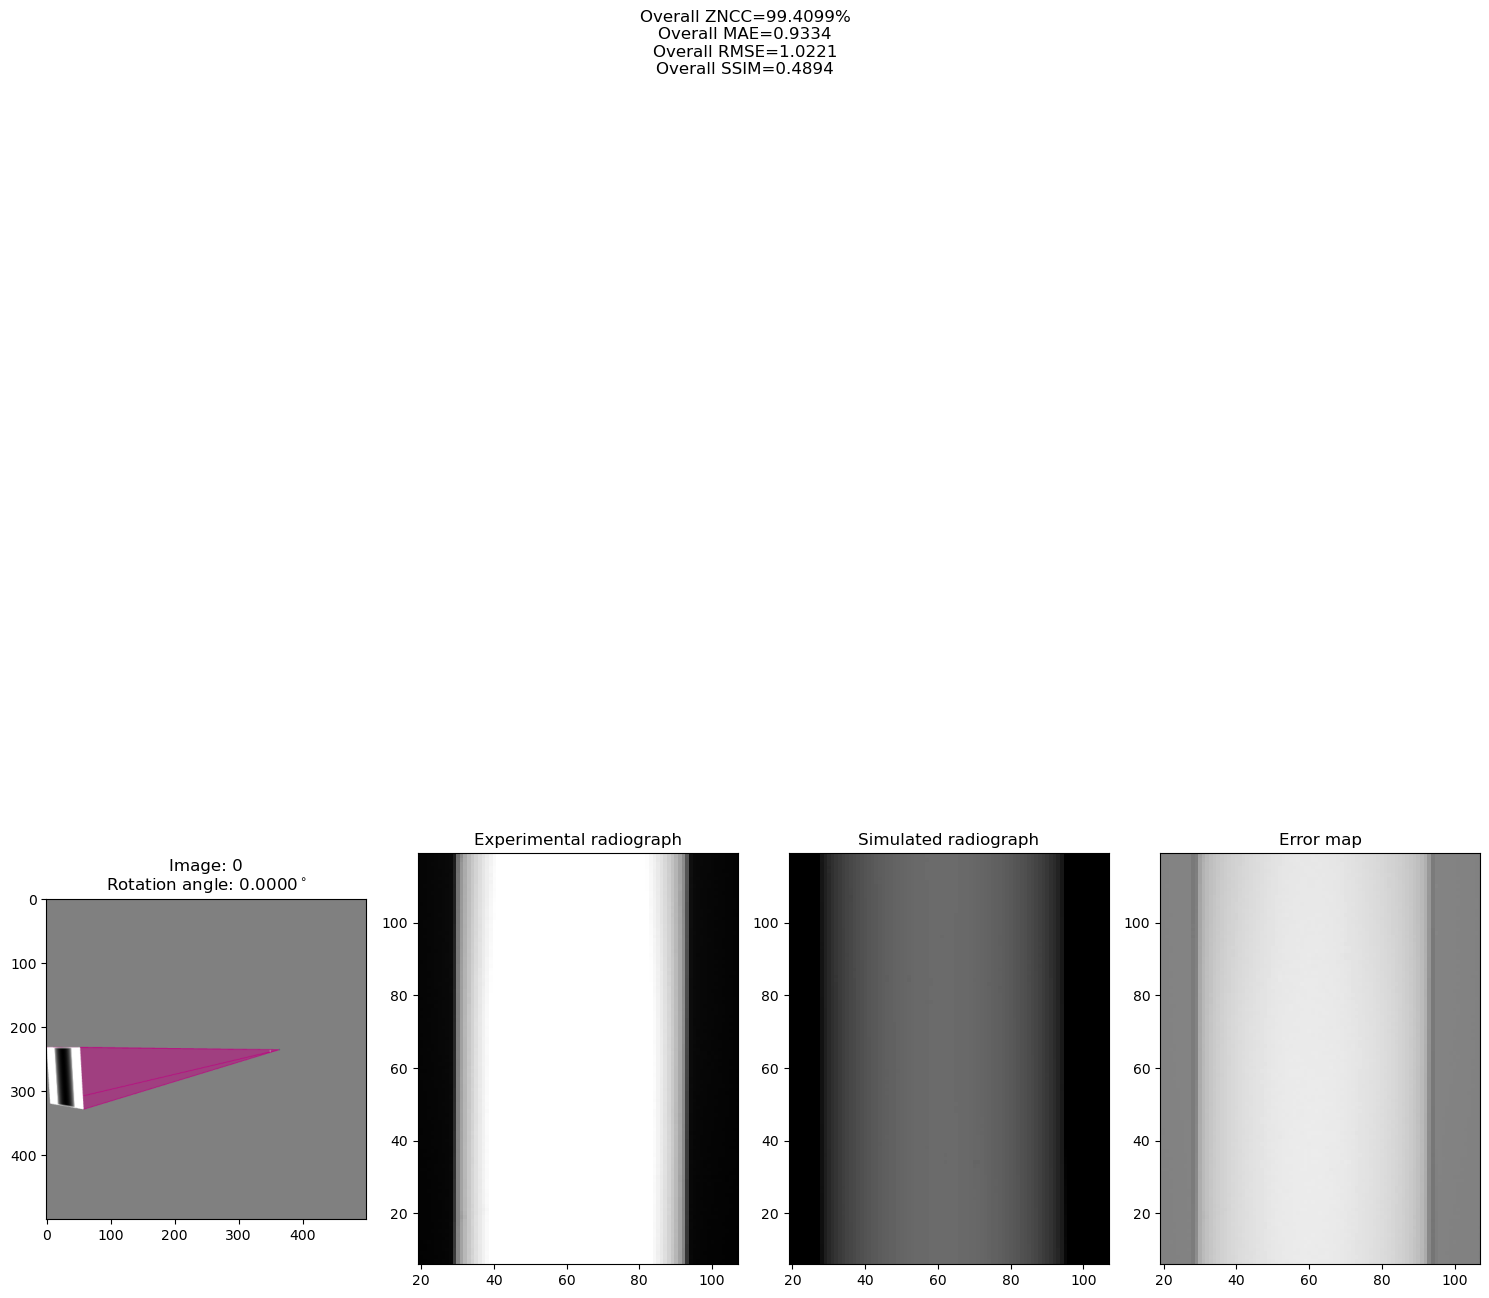

In [16]:
utils.figsize = (15, 21)
displayResult(utils.x_current, figsize=utils.figsize, fname=None, crop=True)

In [17]:
# List all the common filters as a Python dictionary
 
filter_set = {
    "Cu": [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5],
    "Al": [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5],
    "Sn": [0.1, 0.25, 0.5, 1.0],
    "Ag": [0.125, 0.25, 1.0]
};

In [ ]:
import sys
#import time
#from tqdm import tqdm


utils.best_fitness = sys.float_info.max
utils.fitness_set = []
utils.counter = 1
utils.plot_directory = os.path.join(registration_dir, "plot3")
smallest_error = sys.float_info.max;


for material in filter_set.keys():
        from tqdm import tqdm
        for i in tqdm(range(10000)):
    
            for thickness in filter_set[material]:
                if has_xpecgen:
                    loadSpectrumXpecgen(XraykV, filters=[[material, thickness, "mm"]], th_in_deg=12)
                elif has_spekpy:
                    loadSpectrumSpekpy(XraykV, filters=[[material, thickness, "mm"]], th_in_deg=12)
            
        
                rmse = fitnessRMSE(utils.x_current);
        
                if smallest_error > rmse:
                    smallest_error = rmse
                    selected_material = material
                    selected_thickness = thickness
                    


print("Filter used:", selected_thickness, "mm of", selected_material)

  0%|▎                                                                       | 41/10000 [2:28:14<571:17:45, 206.51s/it]

In [20]:
#Update filter


if has_xpecgen:
    loadSpectrumXpecgen(XraykV, filters=[[selected_material, selected_thickness, "mm"]], th_in_deg=12)
elif has_spekpy:
    loadSpectrumSpekpy(XraykV, filters=[[selected_material, selected_thickness, "mm"]], th_in_deg=12)

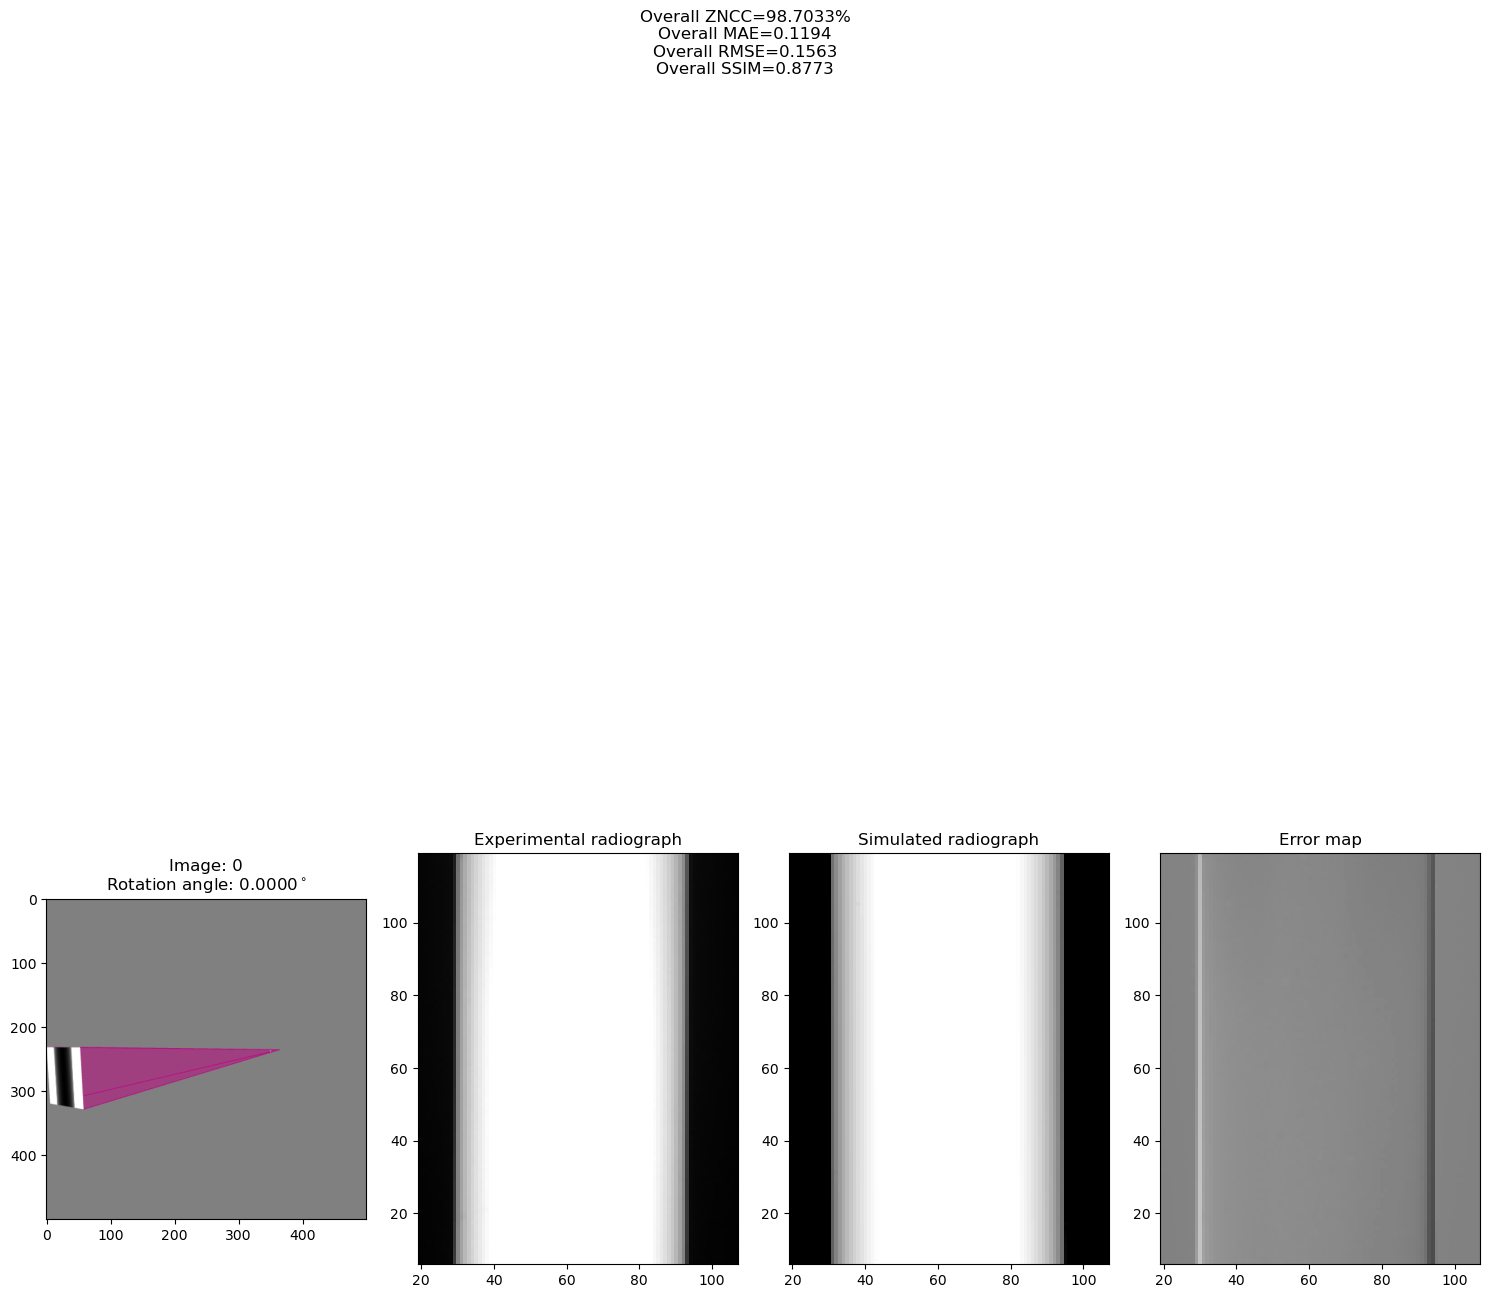

In [21]:
utils.figsize = (15, 21)
displayResult(x_default, figsize=utils.figsize, fname=None, crop=True)

In [ ]:
gvxr.terminate()